# Sentiment Analysis on Manglish Tweets

This notebook implements and evaluates multiple machine learning models for sentiment classification on a dataset of Malay-English (Manglish) tweets. The models explored include:

* **Multinomial Naive Bayes** with TF-IDF features
* **Linear Support Vector Machine (SVM)** with TF-IDF features
* **Logistic Regression** using sentence embeddings from paraphrase-multilingual-MiniLM-L12-v2

Each model is trained on a consistent train-test split to ensure fair comparison. Their performance is evaluated using:

* **Accuracy**
* **Macro-averaged F1 Score**
* **Confusion Matrices**

The three sentiment classes used are: Negative, Neutral, and Positive.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer

from sentence_transformers import SentenceTransformer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\eemrull\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
c:\Users\eemrull\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
data_path = "../data/processed/cleaned_data.csv"
df = pd.read_csv(data_path)

In [3]:
# Split the dataset into training and testing sets (80-20 split)
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Vectorize data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

**1. NLTK Sentiment Analysis (Vader)**

In [5]:
vader = SentimentIntensityAnalyzer()

def vader_to_label(text):
    score = vader.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

y_pred_vdr = X_test.apply(vader_to_label)

**2. Linear Support Vector Classifier**

In [6]:
# Train and Test model with Linear Support Vector Classifier
lsvc = LinearSVC()
lsvc.fit(X_train_vec, y_train)

y_pred_svc = lsvc.predict(X_test_vec)

**3. Multinomial Naive Bayes**

In [7]:
# Train and test model with Multinomial Naive Bayes
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)

y_pred_mnb = mnb.predict(X_test_vec)

**4. Sentence Embeddings from `paraphrase-multilingual-MiniLM-L12-v2` + Logistic Regression Classifier**

In [8]:
# Load SentenceTransformer model and generate embeddings
model_st = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

# Generate embeddings for training and testing data
X_train_emb = model_st.encode(X_train.tolist(), convert_to_numpy=True, batch_size=64)
X_test_emb  = model_st.encode(X_test.tolist(),  convert_to_numpy=True, batch_size=64)

# Train and Test Logistic Regression classifier
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_emb, y_train)

y_pred_emb = logreg.predict(X_test_emb)

**Accuracy & Macro-F1 Scores**

In [9]:
def scores(y_true, y_pred):
    return accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average="macro")

acc_vdr, f1_vdr = scores(y_test, y_pred_vdr)
acc_svc, f1_svc = scores(y_test, y_pred_svc)
acc_mnb, f1_mnb = scores(y_test, y_pred_mnb)
acc_emb, f1_emb = scores(y_test, y_pred_emb)

In [10]:
print(
    f"VADER          –  accuracy: {acc_vdr:.3f}, macro-F1: {f1_vdr:.3f}\n"
    f"LinearSVC      –  accuracy: {acc_svc:.3f},  macro-F1: {f1_svc:.3f}\n"
    f"MultinomialNB  –  accuracy: {acc_mnb:.3f}, macro-F1: {f1_mnb:.3f}\n"
    f"MiniLM+LR      –  accuracy: {acc_emb:.3f}, macro-F1: {f1_emb:.3f}"
)

VADER          –  accuracy: 0.477, macro-F1: 0.351
LinearSVC      –  accuracy: 0.859,  macro-F1: 0.852
MultinomialNB  –  accuracy: 0.789, macro-F1: 0.774
MiniLM+LR      –  accuracy: 0.766, macro-F1: 0.751


**Bar chart (accuracy & macro-F1)**

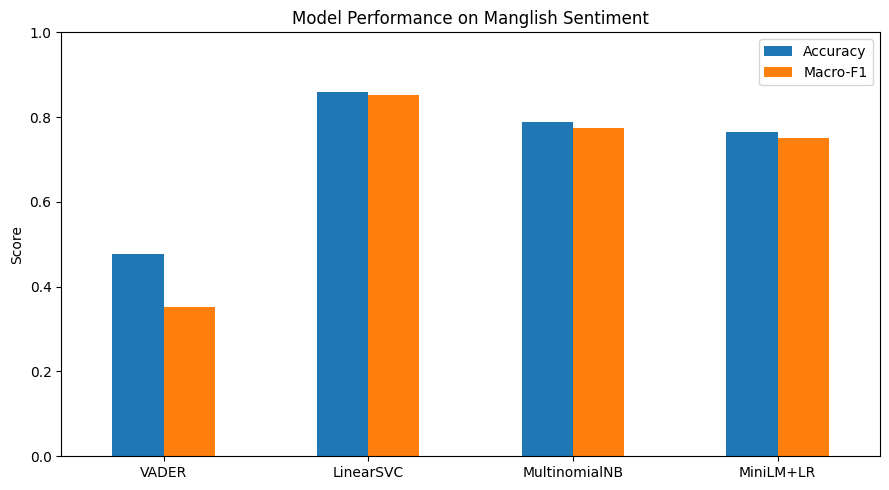

In [11]:
metric_df = pd.DataFrame(
    {
        "VADER":         {"Accuracy": acc_vdr, "Macro-F1": f1_vdr},
        "LinearSVC":     {"Accuracy": acc_svc, "Macro-F1": f1_svc},
        "MultinomialNB": {"Accuracy": acc_mnb, "Macro-F1": f1_mnb},
        "MiniLM+LR":     {"Accuracy": acc_emb, "Macro-F1": f1_emb},
    }
).T

metric_df.plot(kind="bar", figsize=(9, 5))
plt.title("Model Performance on Manglish Sentiment")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.ylabel("Score")
plt.tight_layout()
plt.show()

**Confusion-matrix heat-maps**

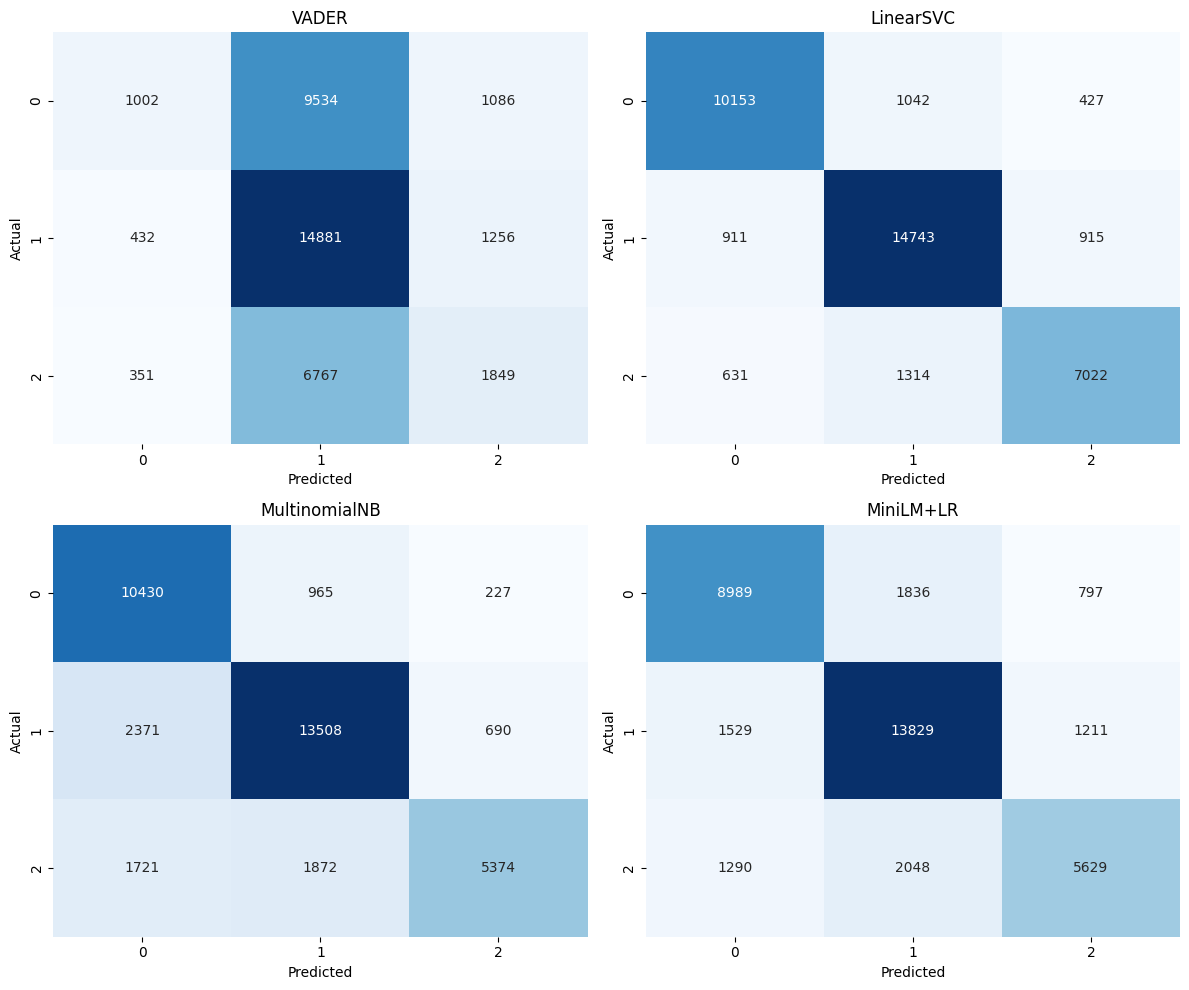

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Plot each confusion matrix
for ax, (name, preds) in zip(
    axes,
    [("VADER", y_pred_vdr),
     ("LinearSVC", y_pred_svc),
     ("MultinomialNB", y_pred_mnb),
     ("MiniLM+LR", y_pred_emb)],
):
    cm = confusion_matrix(y_test, preds, labels=["Negative", "Neutral", "Positive"])
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        cbar=False,
        ax=ax,
    )
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [13]:
# Print confusion matrix values for all models
models_predictions = {
    "VADER": y_pred_vdr,
    "LinearSVC": y_pred_svc,
    "MultinomialNB": y_pred_mnb,
    "MiniLM+LR": y_pred_emb,
}

for model_name, preds in models_predictions.items():
    cm = confusion_matrix(y_test, preds, labels=["Negative", "Neutral", "Positive"])
    print(f"Confusion Matrix for {model_name}:\n{cm}\n")

Confusion Matrix for VADER:
[[ 1002  9534  1086]
 [  432 14881  1256]
 [  351  6767  1849]]

Confusion Matrix for LinearSVC:
[[10153  1042   427]
 [  911 14743   915]
 [  631  1314  7022]]

Confusion Matrix for MultinomialNB:
[[10430   965   227]
 [ 2371 13508   690]
 [ 1721  1872  5374]]

Confusion Matrix for MiniLM+LR:
[[ 8989  1836   797]
 [ 1529 13829  1211]
 [ 1290  2048  5629]]

